In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import RecalibratePredictions
from PREDICT.Metrics import *
from PREDICT.Triggers import TimeframeTrigger
from PREDICT.Plots import *

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Regular Recalibration Example
In this scenario, we have predictions from an existing model but the underlying data changes twice over a year period.

This means there are two dates where the model predictions will be badly calibrated, leading to poor predictions.

We are going to recalibrate the model every 100 days rather than waiting for the model accuracy to decrease.

Recalibration is performed by fitting a logistic regression to adjust the predictions (aka Platt scaling).

# Synthetic Data
We create some fake data where the predictions will go wrong twice during the year.

In [2]:
# Fake data with stepchange in incidence rate to test recalibration
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list()
}
np.random.seed(42)
startDate = pd.to_datetime('01-01-2024', dayfirst=True)
endDate = pd.to_datetime('31-12-2024', dayfirst=True)
switchDate = pd.to_datetime('01-07-2024', dayfirst=True)
switchDate2 = pd.to_datetime('01-10-2024', dayfirst=True)
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days

# Create some semi-realistic data for n = 5000 people
age = np.random.normal(70, 5, 5000)
systolic_bp = np.random.normal(120, 10, 5000)

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)
    
    # Generate predictions
    lp = -1.5 + 0.5 * (age-70)/5 + 2 * (systolic_bp - 120)/10
    curpredictions = 1 / (1 + np.exp(-lp))
    if i >= switchDays:
        # Change to incidence rate
        lp = lp + 2.5
    if i >= switch2Days:
        # Change incidence rate again
        lp = lp - 2.5
    
    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))
        
    # Append to dictionary
    mydict['date'].extend([curday]*5000)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)

df = pd.DataFrame(mydict)
df

,date,outcome,prediction
0,2024-01-01,0,0.109178
1,2024-01-01,0,0.077561
2,2024-01-01,0,0.008430
3,2024-01-01,0,0.198028
4,2024-01-01,1,0.462218
...,...,...,...
1824995,2024-12-30,0,0.746063
1824996,2024-12-30,0,0.005818
1824997,2024-12-30,0,0.205188
1824998,2024-12-30,0,0.473911


# Track accuracy over time and recalibrate

We setup a RegularRecalibration model, and set updates to trigger every month. 
This class already implements the recalibration procedure.
We then setup a PREDICT object and track the metrics, as usual.

In [3]:
model = RecalibratePredictions()
model.trigger = TimeframeTrigger(model=model, updateTimestep=100, dataStart=df['date'].min(), dataEnd=df['date'].max())

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
# mytest.addLogHook(CoxSnellR2(model))
# mytest.addLogHook(AUPRC(model))
# mytest.addLogHook(AUROC(model))
# mytest.addLogHook(F1Score(model))
# mytest.addLogHook(OE(model))
# mytest.addLogHook(Precision(model))
# mytest.addLogHook(Sensitivity(model))
# mytest.addLogHook(Specificity(model))
mytest.addLogHook(SumOfDiff(model))

In [4]:
mytest.run()

In [5]:
# Check dates when the model recalibrated itself
log = mytest.getLog()
if 'Model Updated' in log:
    print(log['Model Updated'])

{Timestamp('2024-05-01 00:00:00'): True, Timestamp('2024-08-01 00:00:00'): True, Timestamp('2024-11-01 00:00:00'): True}


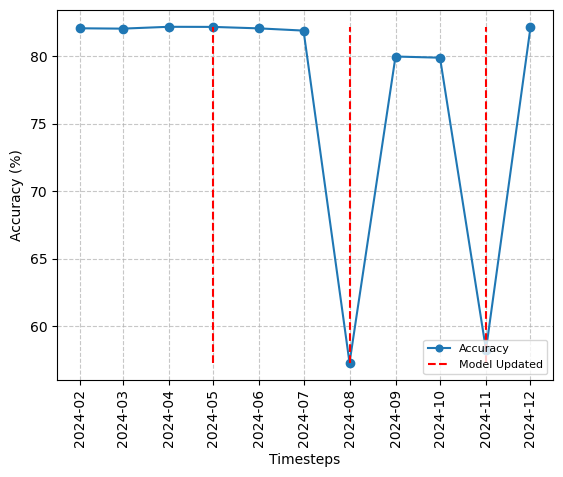

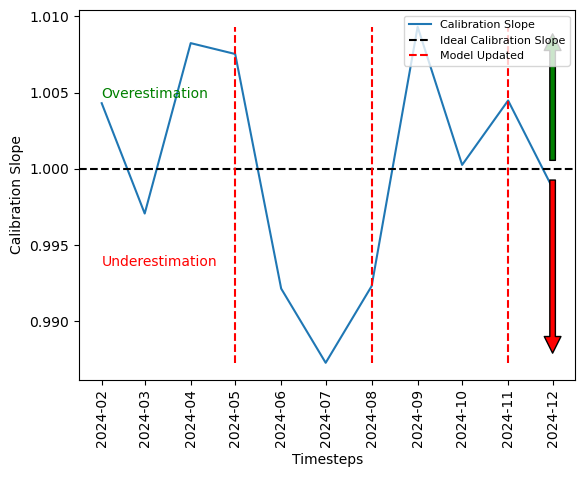

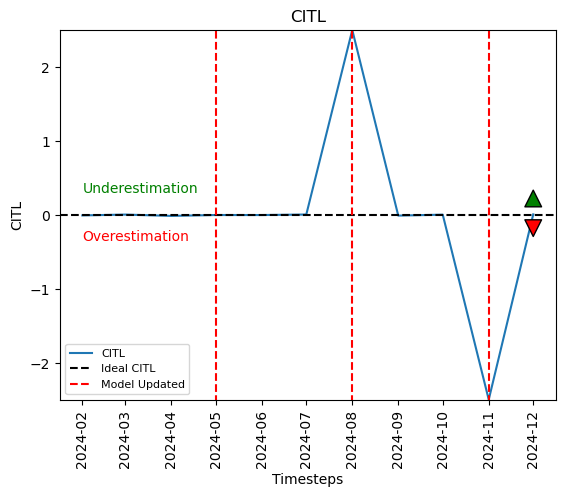

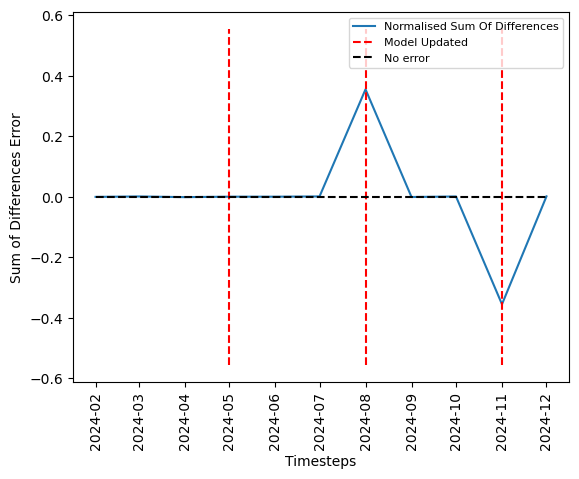

In [7]:
AccuracyPlot(log)
CalibrationSlopePlot(log)
CITLPlot(log)
# CoxSnellPlot(log)
# AUPRCPlot(log)
# AUROCPlot(log)
# F1ScorePlot(log)
# OEPlot(log)
# PrecisionPlot(log)
# SensitivityPlot(log)
# SpecificityPlot(log)
NormalisedSumOfDiffPlot(log)